In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.linear_model import SGDClassifier, LogisticRegression

from sklearn.ensemble import IsolationForest
from sklearn.inspection import permutation_importance
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA, PCA

from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.filterwarnings('ignore') 

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train = train.drop_duplicates()

train,val = train_test_split(train,train_size=0.7,random_state=0)

y_train = train.Survived
X_train = train.drop(columns='Survived')

train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
857,858,1,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
386,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S
124,125,0,1,"White, Mr. Percival Wayland",male,54.0,0,1,35281,77.2875,D26,S
578,579,0,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...
835,836,1,1,"Compton, Miss. Sara Rebecca",female,39.0,1,1,PC 17756,83.1583,E49,C
192,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,NaN,S
629,630,0,3,"O'Connell, Mr. Patrick D",male,NaN,0,0,334912,7.7333,NaN,Q
559,560,1,3,"de Messemaeker, Mrs. Guillaume Joseph (Emma)",female,36.0,1,0,345572,17.4000,NaN,S


In [36]:
nullcnt = X_train.isnull().sum()

nullcnt = nullcnt[nullcnt>0].apply(lambda x: x/X_train.shape[0]).sort_values(ascending=False)

null_col = nullcnt[nullcnt>0.3].index

X_train = X_train.drop(columns=null_col)

nullcnt

Cabin       0.756019
Age         0.194222
Embarked    0.003210
dtype: float64

In [3]:
X_train.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

In [4]:
X_train[X_train.select_dtypes(exclude=np.number).columns].apply(lambda x: x.unique())

Name        [Daly, Mr. Peter Denis , Harper, Mrs. Henry Sl...
Sex                                            [male, female]
Ticket      [113055, PC 17572, CA 2144, 35281, 2689, C.A. ...
Embarked                                       [S, C, Q, nan]
dtype: object

In [5]:
X_train.Name.apply(lambda x: x.split('.')[0].split()[-1]).value_counts()

Mr          367
Miss        121
Mrs          88
Master       31
Rev           3
Dr            3
Mlle          2
Major         2
Ms            1
Mme           1
Countess      1
Lady          1
Capt          1
Sir           1
Name: Name, dtype: int64

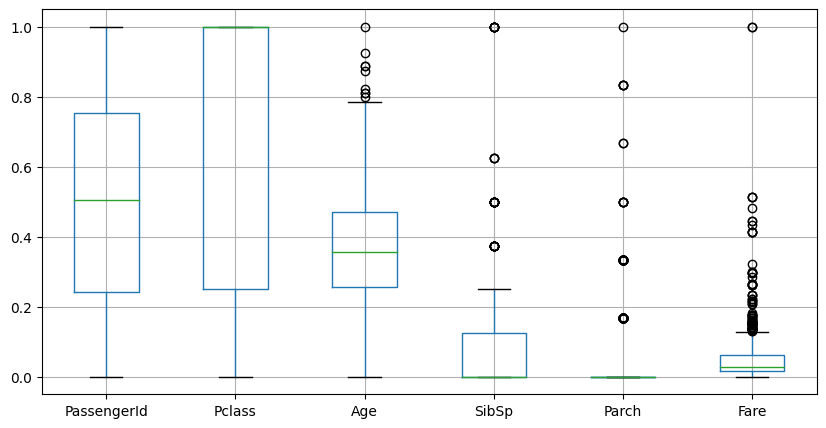

In [6]:
fig,ax = plt.subplots(figsize=(10,5))

numcol_train = X_train.select_dtypes(include=np.number)

boxdf = pd.DataFrame(MinMaxScaler().fit_transform(numcol_train), columns=numcol_train.columns)

boxdf.boxplot()

plt.show()

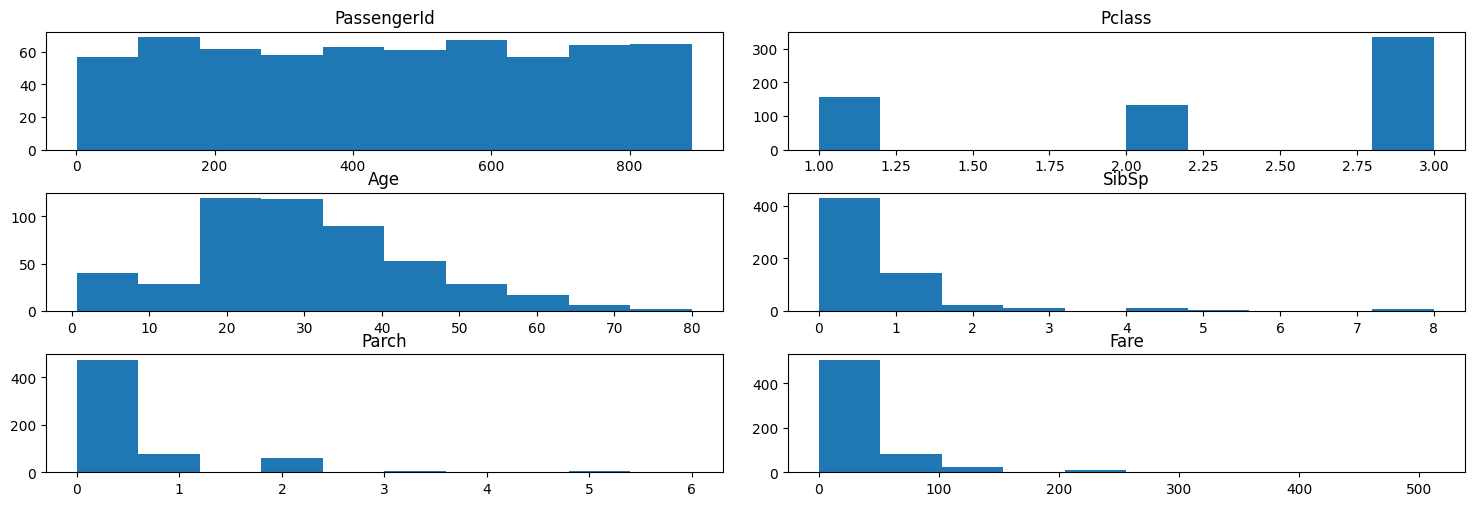

In [7]:
fig,ax = plt.subplots(3,2,figsize=(15,5))
ax = ax.flatten()
fig.tight_layout(w_pad=1, h_pad=1)

for ind,col in enumerate(numcol_train):
    ax[ind].hist(X_train[col])
    ax[ind].set_title(col)
    
plt.show()

In [8]:
X_id = X_train.PassengerId
X_train = X_train.drop(columns='PassengerId')

In [10]:
y_train.value_counts()

0    381
1    242
Name: Survived, dtype: int64

# Imputation and Encoding

In [18]:
class CustomTransformer(TransformerMixin, BaseEstimator): 
    
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        self.X = X
        
        X_transformed = X.applymap(lambda x: x.split('.')[0].split()[-1])
        X_transformed = X_transformed.applymap(lambda x: x.replace('Mlle','Miss').replace('Ms','Miss').replace('Mme','Mrs'))
        X_transformed = X_transformed.applymap(lambda x: x.replace('Dr','Rev').replace('Capt','Rev'))
        
        return X_transformed
    
    def get_feature_names_out(self, _):
        return ['' for i in range(len(self.X.columns))]
    

class CustomTransformer2(TransformerMixin, BaseEstimator): 
    
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        self.X = X
        
        X_transformed = X.applymap(lambda inp: "".join(filter(lambda x: not x.isdigit(), inp)).upper() + ' num')
        X_transformed = X_transformed.applymap(lambda inp: ' '.join(inp.replace('/',' ').replace('.','').split()))
        
        return X_transformed
    
    def get_feature_names_out(self, _):
        return self.X.columns.tolist()

    
num_pipe = Pipeline([
    ('numimp',SimpleImputer(strategy='median'))
])

ordcol_pipe = Pipeline([
    ('ordcolimp',SimpleImputer(strategy='most_frequent')),
    ('ordcolenc',OrdinalEncoder())
])

nomcol_pipe1 = Pipeline([
    ('nomcolimp1',SimpleImputer(strategy='most_frequent')),
    ('nomcoltf',CustomTransformer()),
    ('nomcolenc1',OneHotEncoder(min_frequency=3, handle_unknown='infrequent_if_exist'))
])

nomcol_pipe2 = Pipeline([
    ('nomcolimp2',SimpleImputer(strategy='most_frequent')),
    ('nomcolenc2',OneHotEncoder())
])

nomcol_pipe3 = Pipeline([
    ('nomcolimp3',SimpleImputer(strategy='most_frequent')),
    ('nomcoltf2',CustomTransformer2())
])

preproc_pipeline = ColumnTransformer([
    ('num',num_pipe,X_train.select_dtypes(include=np.number).columns),
    ('ordcol',ordcol_pipe,['Sex']),
    ('nomcol1',nomcol_pipe1,['Name']),
    ('nomcol2',nomcol_pipe2,['Embarked']),
    ('nomcol3',nomcol_pipe3,['Ticket'])
])

In [19]:
def preproc_func(X,mode='train'):
    
    if mode=='train':
        preproc_pipeline.fit(X)
    X_proc = pd.DataFrame(preproc_pipeline.transform(X), 
                          columns=preproc_pipeline.get_feature_names_out())
    
    
    hasher = HashingVectorizer(n_features=2**4, lowercase=False)
    if mode=='train':
        hasher.fit(X_proc.iloc[:,-1])
    hashed = pd.DataFrame(hasher.transform(X_proc.iloc[:,-1]).toarray(), 
                          columns=[f'Ticket_{i}' for i in range(2**4)])
    
    
    X_proc = pd.concat([X_proc.iloc[:,:-1],hashed], axis=1).astype(np.float64)
    
    X_proc['num__nbrel'] = X_proc.num__SibSp + X_proc.num__Parch
    X_proc = X_proc.drop(columns=['num__SibSp','num__Parch'])

    return X_proc

X_proc = preproc_func(X_train)

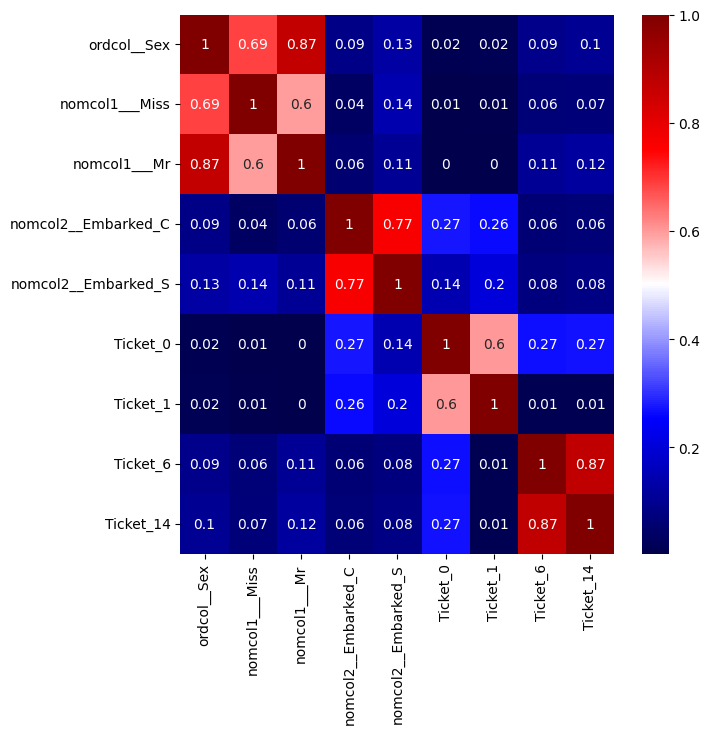

In [21]:
fig,ax = plt.subplots(figsize=(7,7))

corrdf = X_proc.corr().abs()

high_corr_col = corrdf[corrdf.applymap(lambda x: True if (x>=0.6) and (x<1) else False).sum() > 0].index
corrdf_small = corrdf.loc[high_corr_col,high_corr_col]

sns.heatmap(corrdf_small,annot=np.round(corrdf_small,2),cmap='seismic')

plt.show()

In [14]:
# zero_cols = X_proc.loc[:, ~(X_proc != 0).any(axis=0)].columns
# X_proc = X_proc.drop(columns=[*['ordcol__Sex','Ticket_14'],*zero_cols])

# Scaling and Oversampling

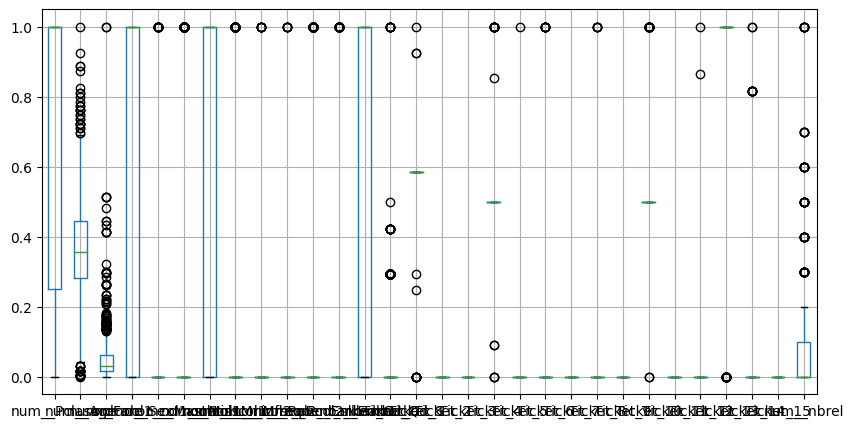

In [22]:
fig,ax = plt.subplots(figsize=(10,5))

numcol_train = X_proc.select_dtypes(include=np.number)

boxdf = pd.DataFrame(MinMaxScaler().fit_transform(numcol_train), columns=numcol_train.columns)

boxdf.boxplot()

plt.show()

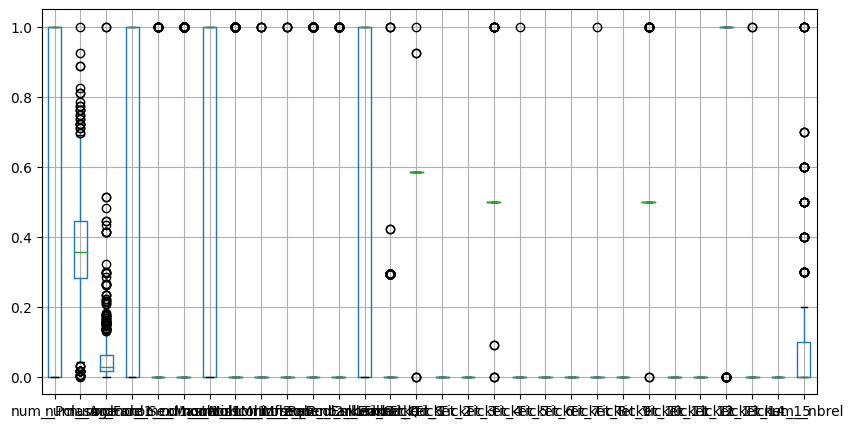

In [23]:
def outlier_removal(X):
    X_or = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X),columns=X.columns)
    isoforest = IsolationForest(contamination=0.05, random_state=0)
    
    stddf = pd.DataFrame(MinMaxScaler().fit_transform(X),columns=X.columns).std().sort_values()
    
    outpred = pd.DataFrame(isoforest.fit_predict(X_or[stddf.head(20).index]))
    inlieind = outpred.loc[outpred[0] == 1].index
    
    X = X.iloc[inlieind]
    return X, inlieind

X_proc_or,index = outlier_removal(X_proc)
y_proc_or = y_train.iloc[index]

fig,ax = plt.subplots(figsize=(10,5))

boxdf = pd.DataFrame(MinMaxScaler().fit_transform(X_proc_or),columns=X_proc_or.columns)

boxdf.boxplot()

plt.show()

In [24]:
scaler = RobustScaler()
scaler.fit(X_proc_or)
X_proc_or = scaler.transform(X_proc_or)

In [25]:
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X_proc_or, y_proc_or)

y_res.value_counts()

1    364
0    364
Name: Survived, dtype: int64

In [26]:
X_res = pd.DataFrame(X_res,columns=X_proc.columns)
X_res

,num__Pclass,num__Age,num__Fare,ordcol__Sex,nomcol1___Master,nomcol1___Miss,nomcol1___Mr,nomcol1___Mrs,nomcol1___Rev,nomcol1___infrequent_sklearn,...,Ticket_7,Ticket_8,Ticket_9,Ticket_10,Ticket_11,Ticket_12,Ticket_13,Ticket_14,Ticket_15,num__nbrel
0,-1.000000,1.692308,0.516060,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,-1.000000,1.538462,2.665062,-1.0,0.0,0.0,-1.000000,1.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,-0.707107,0.0,0.0,1.0
2,-1.000000,1.923077,2.688972,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0
3,0.000000,0.000000,-0.001786,-1.0,0.0,0.0,-1.000000,1.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0
4,-0.500000,-1.615385,0.952891,0.0,1.0,0.0,-1.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.707107,0.0,0.0,0.000000,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,-1.000000,1.592165,0.643698,0.0,0.0,0.0,-0.769815,0.0,0.0,0.769815,...,0.0,0.0,0.0,0.000000,0.0,0.0,-0.162766,0.0,0.0,0.0
724,-1.000000,1.576737,0.516060,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
725,-1.000000,1.725230,2.723353,-1.0,0.0,0.0,-1.000000,1.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0
726,-1.000000,1.225737,5.258337,-1.0,0.0,1.0,-1.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,-0.163657,0.0,0.0,0.0


# Dimensionality Reduction

best n_dimen: 14


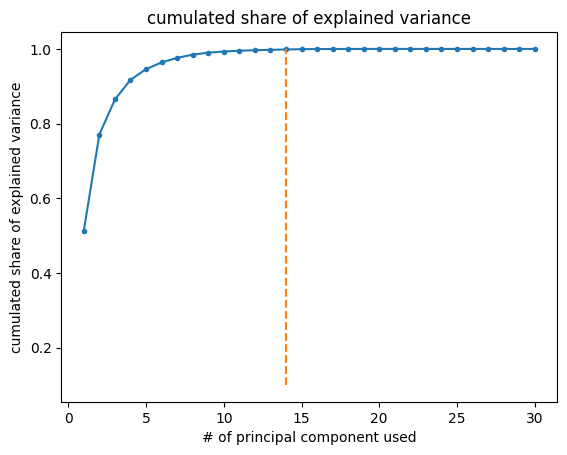

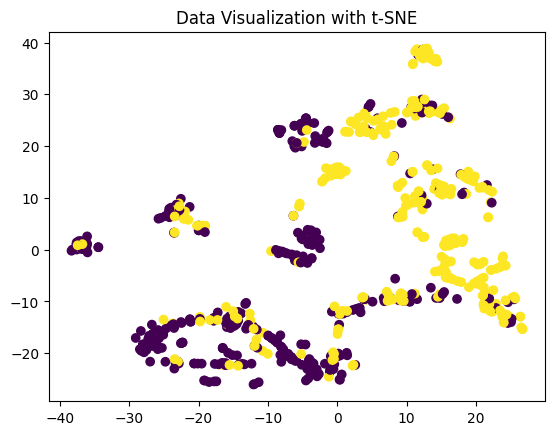

In [40]:
pca_dr = PCA()
pca_dr.fit(X_res)
pcavari = pca_dr.explained_variance_ratio_
n_dimen = np.argmax(np.isclose(np.cumsum(pcavari),1.0,rtol=1e-3))

print(f'best n_dimen: {n_dimen}')

fig1,ax1 = plt.subplots()

ax1.plot([n+1 for n in range(len(pcavari))],np.cumsum(pcavari),'.-')
ax1.plot([n_dimen,n_dimen],[0.1,1.0],'--')
ax1.set_xlabel('# of principal component used')
ax1.set_ylabel('cumulated share of explained variance')
ax1.set_title('cumulated share of explained variance')

pca_comp = PCA(n_components=n_dimen)
X_pca = pd.DataFrame(pca_comp.fit_transform(X_res))


fig2,ax2 = plt.subplots()

tsne_trans = TSNE(random_state=11, perplexity=30,n_components=2)
X_tsne = tsne_trans.fit_transform(X_res)

ax2.scatter(X_tsne[:,0],X_tsne[:,1],c=y_res)
ax2.set_title('Data Visualization with t-SNE')

plt.show()

# Model

In [41]:
grid = {'penalty':['l1','l2','elasticnet'], 
        'C':[10**i for i in range(-6,3)], 
        'l1_ratio':[0.1*i for i in range(0,11)]}

model = LogisticRegression(max_iter=2000,solver='saga')

grid_cv = GridSearchCV(model, grid, scoring='roc_auc', cv=10)
grid_cv.fit(X_pca,y_res)

grid_cv.best_params_

{'C': 10, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}

In [43]:
model = grid_cv.best_estimator_

model.fit(X_pca,y_res)

permutation_score = permutation_importance(model, X_pca, y_res, n_repeats=10, scoring='roc_auc')

importance_df = pd.DataFrame({'feature':X_pca.columns,
                              'Score decrease':np.round(permutation_score.importances_mean, 6)})

importance_df = importance_df.sort_values(by="Score decrease", ascending = False)

importance_df

prec_val = []
nb_features = []

for nb in range(1,int(importance_df.shape[0])+1):
    columns = importance_df.iloc[0:nb].index
    
    X_proc_f = X_pca.iloc[:,columns]
    
    prec = cross_val_score(model, X_proc_f, y_res, cv=5, n_jobs=-1, scoring='roc_auc').mean()
    
    nb_features.append(nb)
    prec_val.append(prec)

optnb_df = pd.DataFrame({'# of Feature':nb_features, 'Accuracy':prec_val})
optnb_df = optnb_df.sort_values(by='Accuracy', ascending=False)

optnb = optnb_df['# of Feature'].iloc[0]

optcol = importance_df.iloc[:optnb+1].feature
model.fit(X_pca[optcol],y_res)

cross_validate(model,X_pca[optcol],y_res,scoring=['accuracy','recall','precision'],cv=5)

{'fit_time': array([0.09107208, 0.08132815, 0.0722096 , 0.07926512, 0.07928061]),
 'score_time': array([0.00434828, 0.00544548, 0.00367141, 0.00447464, 0.00497031]),
 'test_accuracy': array([0.79452055, 0.78082192, 0.80821918, 0.85517241, 0.77931034]),
 'test_recall': array([0.76712329, 0.79452055, 0.80821918, 0.80821918, 0.70833333]),
 'test_precision': array([0.8115942 , 0.77333333, 0.80821918, 0.89393939, 0.82258065])}

# Threshold Adjustment?

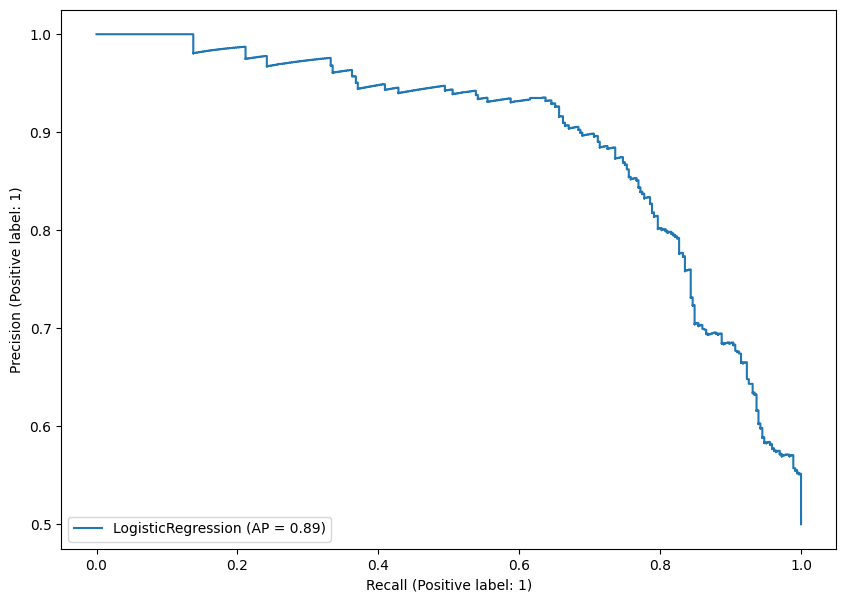

In [44]:
fig,ax = plt.subplots(1,1, figsize=(10,7))

PrecisionRecallDisplay.from_estimator(model, X_pca[optcol], y_res, ax=ax)

plt.show()

In [57]:
y_prob = model.predict_proba(X_pca[optcol])

precision, recall, threshold = precision_recall_curve(y_res, y_prob[:,1])

prc_df = pd.DataFrame(precision,columns=['Precision'])
prc_df['Recall'] = recall

nb_opt = prc_df[prc_df['Recall']>=.85].sort_values('Precision',ascending=False).iloc[1].name
pd.Series({'threshold':threshold[nb_opt],
           'precision':precision[nb_opt],
           'recall':recall[nb_opt]})


threshold    0.290107
precision    0.704545
recall       0.851648
dtype: float64

# Final Test

In [59]:
X_val = val.drop(columns='Survived')
y_val = val.Survived

def generate_prediction(X):
    X_p = preproc_func(X,mode='eval')
    X_p = pd.DataFrame(scaler.transform(X_p), columns=X_p.columns)
    X_p = pd.DataFrame(pca_comp.transform(X_p))
    y = model.predict(X_p[optcol])
#     y_prob = model.predict_proba(X_p[optcol])
#     y = pd.DataFrame(y_prob)[1].apply(lambda x: 1 if x>=threshold[nb_opt] else 0)
    return y

val_pred = generate_prediction(X_val)

print(f'auc: {roc_auc_score(y_val,val_pred)}')
print(f'recall: {recall_score(y_val,val_pred)}')
print(f'accuracy: {accuracy_score(y_val,val_pred)}')
print(f'precision: {precision_score(y_val,val_pred)}')

auc: 0.8316666666666668
recall: 0.83
accuracy: 0.832089552238806
precision: 0.7477477477477478


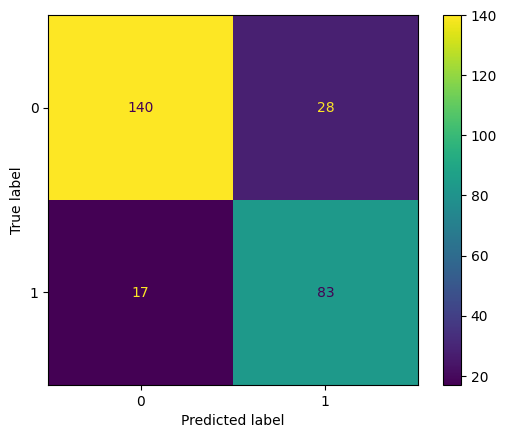

In [60]:
cm = confusion_matrix(y_val, val_pred, labels=model.classes_) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot()
plt.show()

# Prediction

In [52]:
pred = generate_prediction(test)
pred_id = test.PassengerId

predictions = pd.DataFrame({'PassengerId':pred_id, 'Survived':pred})
predictions

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [53]:
with open('data/predictions.csv','w') as file:
    file.write(predictions.to_csv(index=False))

# Preprocessed Dataset

In [67]:
with open('data/preproc_train.csv','w') as file:
    file.write(pd.concat([X_pca, y_res], axis=1).to_csv(index=False))